In [1]:
from abc import ABCMeta
import matplotlib.pyplot as plt
import torch

ModuleNotFoundError: No module named 'dolfinx'

In [144]:
class FiniteDifferenceFunctions():
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = float(dx)
        self.dy = float(dy)
    def grad(self,v):
        v = v.reshape(self.m,self.n)
        return torch.stack(torch.gradient(v,spacing=[self.dx,self.dy],dim=[1,0],edge_order=2))
    def div(self,v):
        v = v.reshape(2,self.m,self.n)
        return torch.gradient(v[0],spacing=[self.dx],dim=[1],edge_order=2)[0]+torch.gradient(v[1],spacing=[self.dy],dim=[0],edge_order=2)[0]
    def divGrad(self,v):
        v = v.reshape(self.m,self.n)
        return self.div(self.grad(v))
    def Agrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return mult(self.A,self.grad(v))
    def divAgrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return self.div(mult(self.A,self.grad(v)))
    
class FiniteDifferenceTensors():
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = float(dx)
        self.dy = float(dy)
    def grad(self):
        n,m = self.n,self.m
        #X-MAT
        x_diag =([-1]+[0]*(m-2)+[1])*(n)
        x_diag_loc = [[i for i in range(m*n)],[i for i in range(m*n)]]
        x_diag = torch.sparse_coo_tensor(x_diag_loc,x_diag,(m*n,m*n))
        print(x_diag.to_dense())
        x_supdiag = spdiags(([0]+([1]+[.5]*(m-2)+[0])*(n)),1,m*n,m*n)
        x_subdiag = spdiags((([-.5]*(m-2)+[-1]+[0])*n),-1,m*n,m*n)
        x_mtrx = x_subdiag + x_diag + x_supdiag
        #Y-MAT
        y_diag = spdiags([-1]*m+[0]*m*(n-2)+[1]*m,0,m*n,m*n)
        y_supdiag = spdiags([0]*m+[1]*m+[.5]*m*(n-2),m,m*n,m*n)
        y_subdiag = spdiags([-.5]*m*(n-2)+[-1]*m+[0]*m,-m,m*n,m*n)
        y_mtrx = y_subdiag + y_diag + y_supdiag
        return np.array([x_mtrx,y_mtrx])
    def div(self):
        return self.grad().T
    def divGrad(self):
        return fdm.div()@fdm.grad()
    def Agrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijk,jk->ik',A,v)
        return mult(self.A,self.grad())
    def divAgrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijk,jk->ik',A,v)
        return self.div()@mult(self.A,self.grad())

In [148]:
m,n = 3,3
x = torch.linspace(-1,1,m)
y = torch.linspace(-1,1,n)
xx,yy = torch.meshgrid(x,y,indexing='xy')
f = xx**2+yy**2
fdm = FiniteDifferenceTensors(m,n,x[1]-x[0],y[1]-y[0])

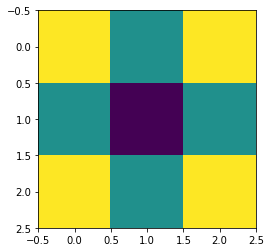

In [149]:
plt.imshow(f)

tensor([[-1,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  1,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, -1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, -1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  1]])


NameError: name 'spdiags' is not defined

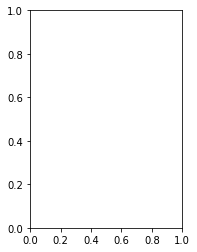

In [150]:
plt.subplot(121)
plt.imshow(fdm.grad().to_dense())
plt.subplot(122)
plt.imshow(fdm.grad(f)[1].flip(dims=(0,)))

tensor([[ 7.0095e-05,  1.4603e-06, -6.8635e-05,  ...,  6.8635e-05,
         -1.4603e-06,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-9.0539e-05,  0.0000e+00,  1.7524e-05,  ..., -1.7524e-05,
          0.0000e+00,  7.3016e-05],
        ...,
        [ 9.0539e-05,  0.0000e+00, -1.7524e-05,  ...,  1.7524e-05,
          0.0000e+00, -7.3016e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.0095e-05,  0.0000e+00,  7.0095e-05,  ..., -7.0095e-05,
          0.0000e+00,  0.0000e+00]])


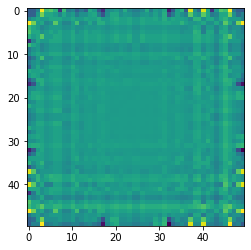

In [133]:
plt.imshow(fdm.divGrad(f))